<a href="https://colab.research.google.com/github/NadiaSV96/labyrinthe-AI/blob/main/TP01_SIMARD_VILLA_Nadia_Labyrinthe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Projet 1 - Résolution de labyrinthe (IA2)**


## Étape 1 — Classe Graphe : structure du labyrinthe


In [ ]:
class Graphe:
    def __init__(self, liste_sommets):
        # La liste des sommets (chaque sommet est une case (i, j) de la grille)
        self.liste_sommets = liste_sommets
        # Dictionnaire des arêtes (clé = sommet, valeur = liste des voisins)
        self.adjacents = {sommet: [] for sommet in liste_sommets}

    def sommets(self):
        # Retourne la liste des sommets
        return self.liste_sommets

    def voisins(self, sommet):
        """
        Retourne la liste des voisins du sommet

        Utilise .get(sommet, []) pour éviter une erreur si le sommet n'existe pas
        encore dans le dictionnaire 'adjacents'. Cela renvoie une liste vide par
        défaut, ce qui rend le code plus solide puisque les sommets
        peuvent être ajoutés dynamiquement.
        """
        return self.adjacents.get(sommet, [])

    def est_voisin(self, s1, s2):
        """
        Vérifie si s2 est un voisin de s1.

        Utilise .get(s1, []) pour éviter une erreur si s1 n'existe pas encore
        dans le dictionnaire. Retourne False dans ce cas.
        """
        return s2 in self.adjacents.get(s1, [])

    def ajoute_sommet(self, sommet):
        # Ajoute un sommet s'il n'existe pas déjà dans le graphe
        # Évite les doublons
        if sommet not in self.liste_sommets:
            self.liste_sommets.append(sommet)
            self.adjacents[sommet] = []

    def ajoute_arete(self, s1, s2):
        # Ajoute les sommets au graphe s'ils n'existent pas encore
        self.ajoute_sommet(s1)
        self.ajoute_sommet(s2)

        """
        On ajoute s2 comme voisin de s1 seulement s'il n'est pas déjà présent.
        Cela évite les doublons dans la liste des voisins,
        ce qui est important pour garder un graphe propre et éviter que les
        algorithmes (comme DFS ou BFS) ne parcourent plusieurs fois le même voisin
        (plus efficace).
        """
        if s2 not in self.adjacents[s1]:
            self.adjacents[s1].append(s2)

        """
        On ajoute s1 comme voisin de s2 seulement s'il n'est pas déjà présent
        (le graphe est non orienté, donc la relation doit exister dans les deux sens).
        """
        if s1 not in self.adjacents[s2]:
            self.adjacents[s2].append(s1)


## Étape 2 — Classe Cellule : murs de chaque case du labyrinthe



In [ ]:
class Cellule:
    def __init__(self, mur_nord, mur_est, mur_sud, mur_ouest):
        """
        Chaque mur est un booléen :
        True = mur présent ; False = mur absent (passage ouvert)
        """
        self.murs = {'N': mur_nord, 'E': mur_est, 'S': mur_sud, 'O': mur_ouest}


## Étape 3 — Classe Labyrinthe (grille et génération du labyrinthe)

In [ ]:
import random

class Labyrinthe:
    def __init__(self, largeur, hauteur):
        """
        Initialise un labyrinthe vide avec une grille de cellules murées.
        """
        self.largeur = largeur  # nombre de colonnes
        self.hauteur = hauteur  # nombre de rangées
        self.grille = self.construire_grille(hauteur, largeur) # est une matrice
        # (liste de listes) contenant des objets Cellule avec tous les murs activés (True)

    def construire_grille(self, h, l):
        """
        Construit une grille de dimensions h x l remplie de cellules avec tous les murs.
        Retourne une matrice [[Cellule]].
        """
        return [[Cellule(True, True, True, True) for _ in range(l)] for _ in range(h)]

    def creer_passage(self, i1, j1, i2, j2):
        """
        Crée une ouverture entre les cellules (i1, j1) et (i2, j2),
        en retirant le mur dans la bonne direction des deux cellules.
        """
        dx = i2 - i1
        dy = j2 - j1

        if dx == 1:  # i2 est en dessous de i1 (direction vers le bas)
            self.grille[i1][j1].murs['S'] = False
            self.grille[i2][j2].murs['N'] = False
        elif dx == -1:  # i2 est au-dessus (direction vers le haut)
            self.grille[i1][j1].murs['N'] = False
            self.grille[i2][j2].murs['S'] = False
        elif dy == 1:  # j2 est à droite (direction vers la droite)
            self.grille[i1][j1].murs['E'] = False
            self.grille[i2][j2].murs['O'] = False
        elif dy == -1:  # j2 est à gauche (direction vers la gauche)
            self.grille[i1][j1].murs['O'] = False
            self.grille[i2][j2].murs['E'] = False

    def creer_labyrinthe(self, i, j, di, dj):
        """
        Génère un labyrinthe parfait de dimension (di, dj) en partant de
        la case (i, j) et en explorant aléatoirement ses voisins.
        """
        traites = set()
        pile = [(i, j)]
        traites.add((i, j))

        while pile:
            ci, cj = pile[-1]
            voisins = []

            for (ni, nj) in [(ci-1, cj), (ci+1, cj), (ci, cj-1), (ci, cj+1)]:
                if 0 <= ni < di and 0 <= nj < dj and (ni, nj) not in traites:
                    voisins.append((ni, nj))

            if voisins:
                vi, vj = random.choice(voisins)
                self.creer_passage(ci, cj, vi, vj)
                pile.append((vi, vj))
                traites.add((vi, vj))
            else:
                pile.pop()

    def definir_entree_sortie(self):
        """
        Choisit aléatoirement une entrée et une sortie sur les bords du labyrinthe,
        ouvre les murs correspondants, et retourne les coordonnées (entrée, sortie).
        """
        bords = []

        # Cellules avec bord haut
        for j in range(self.largeur):
            bords.append(((0, j), 'N'))

        # Cellules avec bord bas
        for j in range(self.largeur):
            bords.append(((self.hauteur - 1, j), 'S'))

        # Cellules avec bord gauche
        for i in range(self.hauteur):
            bords.append(((i, 0), 'O'))

        # Cellules avec bord droit
        for i in range(self.hauteur):
            bords.append(((i, self.largeur - 1), 'E'))

        # Choisir deux points différents
        entree_cell, entree_mur = random.choice(bords)
        sortie_cell, sortie_mur = random.choice(bords)
        while sortie_cell == entree_cell:
            sortie_cell, sortie_mur = random.choice(bords)

        # Ouvrir les murs
        self.grille[entree_cell[0]][entree_cell[1]].murs[entree_mur] = False
        self.grille[sortie_cell[0]][sortie_cell[1]].murs[sortie_mur] = False

        return entree_cell, sortie_cell



### Petite explication pour la création des passages et ouverture des murs

| Déplacement    | Position cible `(i2, j2)` | `dx = i2 - i1` | `dy = j2 - j1` | Direction   |
| -------------- | ------------------------- | -------------- | -------------- | ----------- |
| Vers le haut   | `(i1 - 1, j1)`            | `-1`           | `0`            | Nord (`N`)  |
| Vers le bas    | `(i1 + 1, j1)`            | `+1`           | `0`            | Sud (`S`)   |
| Vers la gauche | `(i1, j1 - 1)`            | `0`            | `-1`           | Ouest (`O`) |
| Vers la droite | `(i1, j1 + 1)`            | `0`            | `+1`           | Est (`E`)   |


> Ces calculs sont utilisés pour déterminer dans quelle direction se trouve une cellule voisine
> afin d’ouvrir les bons murs entre deux cellules adjacentes dans le labyrinthe.


### Génération d’un labyrinthe parfait avec DFS aléatoire

La méthode `creer_labyrinthe(i, j, di, dj)` codée plus haut permet de générer un labyrinthe parfait de dimensions `(di, dj)` en partant de la cellule `(i, j)` pour son exploration. Elle utilise une version itérative du parcours en profondeur (DFS) avec une pile pour simuler l’exploration et une touche d’aléatoire (random) pour produire des labyrinthes uniques à chaque exécution.

L’algorithme fonctionne comme suit :
- On initialise un ensemble `traites` pour mémoriser les cellules déjà explorées.
- Une pile `pile` contient les cellules à visiter. On commence avec la cellule de départ.
- Tant que la pile n’est pas vide :
  - On regarde la cellule au sommet de la pile (`ci, cj`) sans la retirer.
  - On identifie les voisins valides (non traités et dans les limites de la grille).
  On utilise la ligne suivante pour générer les coordonnées des quatre voisins possibles d’une cellule `(ci, cj)` :
  ```python
  for (ni, nj) in [(ci-1, cj), (ci+1, cj), (ci, cj-1), (ci, cj+1)]
  ```
  >Ensuite, on applique une condition qui permet de s’assurer que le voisin est bien dans les limites du labyrinthe (ni et nj ne sortent pas de la grille) et qu’il n’a pas déjà été visité (`traites`). Si c’est le cas, on l’ajoute à la liste des voisins accessibles pour continuer la génération du labyrinthe.

  - Si des voisins valides existent :
    - On en choisit un au hasard (`vi, vj`).
    - On crée un passage entre la cellule actuelle et ce voisin (`creer_passage()` retire les murs).
    - On ajoute ce voisin à la pile et à l’ensemble `traites`.
  - S’il n’y a plus de voisins disponibles, on retire la cellule actuelle de la pile (retour en arrière).

>Ce procédé se répète jusqu’à ce que toutes les cellules aient été explorées. Le labyrinthe obtenu est parfait : il relie toutes les cellules sans aucun cycle, ce qui garantit un unique chemin entre deux points.


#### Affichage du labyrinthe avec matplotlib

In [ ]:
import matplotlib.pyplot as plt

def afficher_labyrinthe(labyrinthe):
    """
    Affiche un labyrinthe à l'aide de matplotlib en traçant les murs des cellules.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.axis('off')

    h = labyrinthe.hauteur
    l = labyrinthe.largeur

    for i in range(h):
        for j in range(l):
            x, y = j, h - i - 1  # Inverser y pour affichage de haut en bas
            murs = labyrinthe.grille[i][j].murs

            # Tracer les murs si True
            if murs['N']:
                ax.plot([x, x + 1], [y + 1, y + 1], color='black')
            if murs['S']:
                ax.plot([x, x + 1], [y, y], color='black')
            if murs['O']:
                ax.plot([x, x], [y, y + 1], color='black')
            if murs['E']:
                ax.plot([x + 1, x + 1], [y, y + 1], color='black')

    plt.show()


### Conversion du labyrinthe en graphe

Chaque cellule du labyrinthe devient un sommet dans le graphe.  
Une arête est ajoutée entre deux cellules adjacentes s'il n'y a pas de mur entre elles.

Exemple :  
- Si la cellule `(2, 3)` n’a pas de mur à l’est et qu’elle est dans la grille,  
  on ajoute une arête entre `(2, 3)` et `(2, 4)`.
- Le graphe obtenu est non orienté (les arêtes vont dans les deux sens).

Cela permet ensuite d'appliquer des algorithmes de recherche de chemin (DFS, BFS, Dijkstra, A*, etc.).


In [ ]:
def labyrinthe_vers_graphe(labyrinthe):
    # Récupère les dimensions du labyrinthe
    h, l = labyrinthe.hauteur, labyrinthe.largeur

    # Crée une liste de tous les sommets (chaque cellule est un sommet identifié par ses coordonnées)
    sommets = [(i, j) for i in range(h) for j in range(l)]

    # Initialise un objet Graphe avec tous les sommets
    graphe = Graphe(sommets)

    # Parcourt chaque cellule du labyrinthe
    for i in range(h):
        for j in range(l):
            cell = labyrinthe.grille[i][j]  # cellule courante

            # Si pas de mur au nord et qu'on n'est pas sur la première ligne, ajoute une arête vers le voisin du haut
            if not cell.murs['N'] and i > 0:
                graphe.ajoute_arete((i, j), (i - 1, j))

            # Si pas de mur au sud et qu'on n'est pas sur la dernière ligne, ajoute une arête vers le voisin du bas
            if not cell.murs['S'] and i < h - 1:
                graphe.ajoute_arete((i, j), (i + 1, j))

            # Si pas de mur à l’est et qu'on n'est pas sur la dernière colonne, ajoute une arête vers le voisin de droite
            if not cell.murs['E'] and j < l - 1:
                graphe.ajoute_arete((i, j), (i, j + 1))

            # Si pas de mur à l’ouest et qu'on n'est pas sur la première colonne, ajoute une arête vers le voisin de gauche
            if not cell.murs['O'] and j > 0:
                graphe.ajoute_arete((i, j), (i, j - 1))

    # Retourne l'objet Graphe construit à partir de la structure du labyrinthe
    return graphe


#### Affichage du graphe avec matplotlib

In [ ]:
import matplotlib.pyplot as plt

def afficher_graphe(graphe, hauteur, entree=None, sortie=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.axis('off')

    # Titre du graphe
    ax.set_title("Graphe (arbre couvrant) du labyrinthe", fontsize=14)

    for sommet in graphe.sommets():
        x, y = sommet[1], hauteur - sommet[0] - 1
        for voisin in graphe.voisins(sommet):
            vx, vy = voisin[1], hauteur - voisin[0] - 1
            ax.plot([x + 0.5, vx + 0.5], [y + 0.5, vy + 0.5], color='blue')

    for sommet in graphe.sommets():
        x, y = sommet[1], hauteur - sommet[0] - 1

        if sommet == entree:
            color = 'green'
        elif sommet == sortie:
            color = 'red'
        else:
            color = 'purple'

        ax.plot(x + 0.5, y + 0.5, 'o', color=color, markersize=4)

    # Légende
    ax.plot([], [], ' ', label='Point vert = entrée')
    ax.plot([], [], ' ', label='Point rouge = sortie')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

    plt.show()


### Appel des classes et fonctions pour construire et afficher le labyrinthe ainsi que son graphe dans le notebook colab

Entrée : (0, 12)
Sortie : (39, 18)


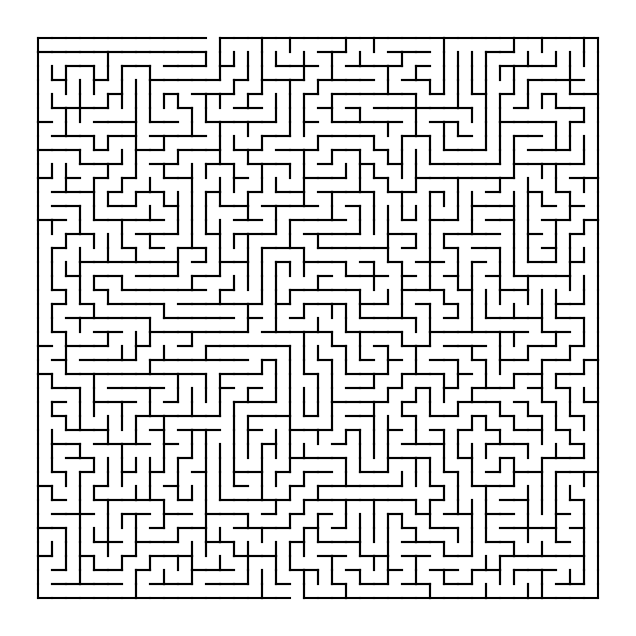

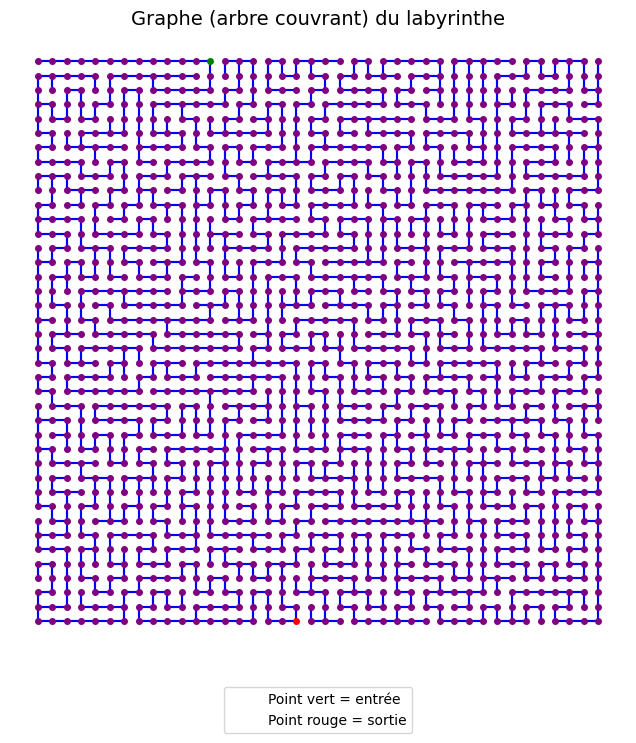

In [ ]:
lab = Labyrinthe(40, 40)  # Création d'un objet labyrinthe de dimensions 40x40
lab.creer_labyrinthe(0, 0, 40, 40)  # Génération du labyrinthe parfait
entree, sortie = lab.definir_entree_sortie()

print("Entrée :", entree)
print("Sortie :", sortie)

# Afficher le labyrinthe
afficher_labyrinthe(lab)

# Construire et afficher le graphe
graphe_lab = labyrinthe_vers_graphe(lab)
afficher_graphe(graphe_lab, lab.hauteur, entree=entree, sortie=sortie)


## Étape 4 — Algorithmes de recherche

Implémentation des algorithmes de recherche sur le graphe du labyrinthe :  
DFS (profondeur), BFS (largeur), Dijkstra et A* (avec heuristique de Manhattan).  
Chaque algorithme renverra le chemin trouvé ainsi que des métriques de comparaison :
- Longueur du chemin
- Nombre de nœuds explorés
- Ratio d'exploration
- Temps d'exécution


### Fonction utilitaire : reconstruction de chemin


In [ ]:
def recupere_chemin(depart, arrivee, parent):
    """
    Reconstitue le chemin du départ à l'arrivée en remontant les parents.
    """
    chemin = []
    actuel = arrivee                   # Commence de la fin et on va remonter
    while actuel is not None:
        chemin.append(actuel)          # Ajouter le sommet courant au chemin
        actuel = parent.get(actuel)    # Remonter au parent précédent
    chemin.reverse()                   # Inverser l'ordre pour avoir le chemin correct
    return chemin


>J'ai décidé de définir cette fonction avant les fonctions de recherche puisque je vais l'appeler dans chaque cellule d'algorithme.

Chaque algorithme de recherche (DFS, BFS, Dijkstra, A*) construit un dictionnaire `parent` de la forme :

```python
parent = {
    sommet1: parent_de_sommet1,
    sommet2: parent_de_sommet2,
    ...
}
```

Ce dictionnaire permet de reconstituer le chemin du départ à l’arrivée. Pour chaque sommet, on enregistre le sommet par lequel on est arrivé à lui.

### Import des bibliothèques pour les algorithmes

In [ ]:
import time
from math import inf

### DFS, Depth First Search

In [ ]:
def DFS(g, depart, arrivee):
    """
    Parcours en profondeur (DFS) du graphe g en partant du sommet 'depart'.
    S'arrête dès que le sommet 'arrivee' est atteint.
    Renvoie le chemin du départ à l'arrivée.
    Affiche les métriques : longueur du chemin, nombre de nœuds explorés, temps d'exécution.
    """

    debut = time.time()  # Démarrer le chronomètre

    traites = set()         # Ensemble des sommets déjà visités
    pile = [depart]         # Structure LIFO pour le DFS
    parent = {depart: None} # Dictionnaire pour reconstruire le chemin
    noeuds_explores = 0     # Compteur de noeuds traités

    while pile:
        actuel = pile.pop()       # Récupère le sommet en haut de la pile
        noeuds_explores += 1      # Ajout au compteur

        if actuel == arrivee:     # Arrêt dès qu'on atteint l'arrivée
            break

        if actuel not in traites:
            traites.add(actuel)

            # Parcours des voisins en ordre inversé pour respecter la logique DFS
            for voisin in reversed(g.voisins(actuel)):
                if voisin not in traites and voisin not in parent:
                    pile.append(voisin)
                    parent[voisin] = actuel  # Enregistrer le parent pour reconstruire le chemin

    fin = time.time()  # Arrêter le chronomètre

    chemin = recupere_chemin(depart, arrivee, parent)  # Reconstruire le chemin final

    resume = {
        "Algorithme": "DFS",
        "Longueur du chemin": len(chemin),
        "Noeuds explorés": noeuds_explores,
        "Ratio exploration": round(noeuds_explores / len(chemin), 2),
        "Temps (s)": round(fin - debut, 6)
    }

    return chemin, resume


In [ ]:
chemin_dfs, resultat_dfs = DFS(graphe_lab, entree, sortie)
print("DFS :")
print("Longueur du chemin :", resultat_dfs["Longueur du chemin"])
print("Noeuds explorés    :", resultat_dfs["Noeuds explorés"])
print("Ratio exploration   :", resultat_dfs["Ratio exploration"])
print("Temps d'exécution  :", resultat_dfs["Temps (s)"], "secondes")
print("Chemin :", chemin_dfs)

DFS :
Longueur du chemin : 642
Noeuds explorés    : 1100
Ratio exploration   : 1.71
Temps d'exécution  : 0.001897 secondes
Chemin : [(0, 12), (1, 12), (2, 12), (2, 11), (2, 10), (2, 9), (2, 8), (1, 8), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5), (3, 4), (4, 4), (4, 3), (3, 3), (2, 3), (2, 2), (3, 2), (4, 2), (4, 1), (3, 1), (3, 0), (4, 0), (5, 0), (5, 1), (6, 1), (6, 0), (7, 0), (7, 1), (7, 2), (7, 3), (8, 3), (8, 4), (8, 5), (7, 5), (7, 6), (8, 6), (9, 6), (9, 5), (10, 5), (10, 4), (11, 4), (12, 4), (12, 5), (12, 6), (12, 7), (11, 7), (11, 8), (12, 8), (12, 9), (13, 9), (13, 8), (13, 7), (13, 6), (14, 6), (14, 7), (15, 7), (15, 8), (15, 9), (14, 9), (14, 10), (13, 10), (12, 10), (11, 10), (10, 10), (10, 9), (10, 8), (9, 8), (9, 7), (8, 7), (8, 8), (8, 9), (7, 9), (7, 10), (7, 11), (7, 12), (6, 12), (6, 11), (5, 11), (4, 11), (4, 10), (3, 10), (3, 11), (3, 12), (3, 13), (2, 13), (2, 14), (1, 14), (0, 14), (0, 15), (1, 15), (2, 15), (3, 15), (3, 14), (4, 14), (4, 13), (5, 13), (5, 14), (5, 

### BFS, Breadth First Search

In [ ]:
def BFS(g, depart, arrivee):
    """
    Parcours en largeur (BFS) du graphe g en partant du sommet 'depart'.
    S'arrête dès que le sommet 'arrivee' est atteint.
    Renvoie le chemin du départ à l'arrivée.
    Affiche les métriques : longueur du chemin, nombre de nœuds explorés, temps d'exécution.
    """

    debut = time.time()  # Démarrer le chronomètre

    traites = []              # Liste des sommets complètement explorés (traités)
    decouverts = [depart]     # Sommets découverts
    en_attente = [depart]     # Structure FIFO pour le BFS
    parent = {depart: None}   # Dictionnaire pour reconstruire le chemin
    noeuds_explores = 0       # Compteur de noeuds traités

    while en_attente != []:
        sommet = en_attente.pop(0)  # Prend le sommet en tête de file
        noeuds_explores += 1        # Ajout au compteur

        # Arrêt dès qu'on atteint l'arrivée
        if sommet == arrivee:
            break

        # Explore les voisins non encore découverts
        for voisin in g.voisins(sommet):
            if voisin not in decouverts:
                decouverts.append(voisin)
                en_attente.append(voisin)
                parent[voisin] = sommet  # Enregistrer le parent pour reconstruire le chemin

        traites.append(sommet)  # Marque le sommet comme traité

    fin = time.time()  # Arrêter le chronomètre

    chemin = recupere_chemin(depart, arrivee, parent)  # Reconstruire le chemin final

    resume = {
        "Algorithme": "BFS",
        "Longueur du chemin": len(chemin),
        "Noeuds explorés": noeuds_explores,
        "Ratio exploration": round(noeuds_explores / len(chemin), 2),
        "Temps (s)": round(fin - debut, 6)
    }

    return chemin, resume


In [ ]:
chemin_bfs, resultat_bfs = BFS(graphe_lab, entree, sortie)
print("Chemin BFS :")
print("Longueur du chemin :", resultat_bfs["Longueur du chemin"])
print("Noeuds explorés    :", resultat_bfs["Noeuds explorés"])
print("Ratio exploration   :", resultat_bfs["Ratio exploration"])
print("Temps d'exécution  :", resultat_bfs["Temps (s)"], "secondes")
print("Chemin :", chemin_bfs)

Chemin BFS :
Longueur du chemin : 642
Noeuds explorés    : 1165
Ratio exploration   : 1.81
Temps d'exécution  : 0.068225 secondes
Chemin : [(0, 12), (1, 12), (2, 12), (2, 11), (2, 10), (2, 9), (2, 8), (1, 8), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5), (3, 4), (4, 4), (4, 3), (3, 3), (2, 3), (2, 2), (3, 2), (4, 2), (4, 1), (3, 1), (3, 0), (4, 0), (5, 0), (5, 1), (6, 1), (6, 0), (7, 0), (7, 1), (7, 2), (7, 3), (8, 3), (8, 4), (8, 5), (7, 5), (7, 6), (8, 6), (9, 6), (9, 5), (10, 5), (10, 4), (11, 4), (12, 4), (12, 5), (12, 6), (12, 7), (11, 7), (11, 8), (12, 8), (12, 9), (13, 9), (13, 8), (13, 7), (13, 6), (14, 6), (14, 7), (15, 7), (15, 8), (15, 9), (14, 9), (14, 10), (13, 10), (12, 10), (11, 10), (10, 10), (10, 9), (10, 8), (9, 8), (9, 7), (8, 7), (8, 8), (8, 9), (7, 9), (7, 10), (7, 11), (7, 12), (6, 12), (6, 11), (5, 11), (4, 11), (4, 10), (3, 10), (3, 11), (3, 12), (3, 13), (2, 13), (2, 14), (1, 14), (0, 14), (0, 15), (1, 15), (2, 15), (3, 15), (3, 14), (4, 14), (4, 13), (5, 13), (5, 14

### Dijkstra

In [ ]:
def Dijkstra(g, depart, arrivee):
    """
    Algorithme de Dijkstra adapté à un graphe g non pondéré.
    S'arrête dès que le noeud s_min 'arrivee' est atteint.
    Calcule le plus court chemin de 'depart' à 'arrivee'.
    Affiche les métriques : longueur du chemin, nœuds explorés, temps d'exécution.
    """

    debut = time.time()    # Démarrer le chronomètre

    distances = {s: [inf, None] for s in g.sommets()}  # {sommet: [distance, parent]}
    distances[depart] = [0, None]

    visites = []           # Sommets déjà traités
    decouverts = [depart]  # Sommets en attente de traitement
    noeuds_explores = 0    # Compteur de noeuds traités

    while decouverts:
        # Trouver le sommet avec la plus petite distance estimée
        dmin = inf
        for s in decouverts:
            if distances[s][0] < dmin:
                dmin = distances[s][0]
                s_min = s

        decouverts.remove(s_min)
        visites.append(s_min)
        noeuds_explores += 1  # Ajout au compteur

        # Arrêt dès qu'on atteint l'arrivée
        if s_min == arrivee:
            break

        for voisin in [v for v in g.voisins(s_min) if v not in visites]:
            if voisin not in decouverts:
                decouverts.append(voisin)
                distances[voisin] = [distances[s_min][0] + 1, s_min]

                # Le + 1 signifie que chaque arête a un poids de 1 dans le labyrinthe

            else:
                if distances[s_min][0] + 1 < distances[voisin][0]:  # Si cette nouvelle distance est plus petite que celle enregistrée dans le dictionnaire
                    distances[voisin] = [distances[s_min][0] + 1, s_min]

    fin = time.time()    # Arrêter le chronomètre

    # Reconstruire le chemin depuis les parents
    parent = {s: distances[s][1] for s in distances if distances[s][1] is not None or s == depart}
    chemin = recupere_chemin(depart, arrivee, parent)

    resume = {
        "Algorithme": "Dijkstra",
        "Longueur du chemin": len(chemin),
        "Noeuds explorés": noeuds_explores,
        "Ratio exploration": round(noeuds_explores / len(chemin), 2),
        "Temps (s)": round(fin - debut, 6)
    }

    return chemin, resume


In [ ]:
chemin_dijkstra, resultat_dijkstra = Dijkstra(graphe_lab, entree, sortie)
print("Chemin Dijkstra :")
print("Longueur du chemin :", resultat_dijkstra["Longueur du chemin"])
print("Noeuds explorés    :", resultat_dijkstra["Noeuds explorés"])
print("Ratio exploration   :", resultat_dijkstra["Ratio exploration"])
print("Temps d'exécution  :", resultat_dijkstra["Temps (s)"], "secondes")
print("Chemin :", chemin_dijkstra)

Chemin Dijkstra :
Longueur du chemin : 642
Noeuds explorés    : 1165
Ratio exploration   : 1.81
Temps d'exécution  : 0.06199 secondes
Chemin : [(0, 12), (1, 12), (2, 12), (2, 11), (2, 10), (2, 9), (2, 8), (1, 8), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5), (3, 4), (4, 4), (4, 3), (3, 3), (2, 3), (2, 2), (3, 2), (4, 2), (4, 1), (3, 1), (3, 0), (4, 0), (5, 0), (5, 1), (6, 1), (6, 0), (7, 0), (7, 1), (7, 2), (7, 3), (8, 3), (8, 4), (8, 5), (7, 5), (7, 6), (8, 6), (9, 6), (9, 5), (10, 5), (10, 4), (11, 4), (12, 4), (12, 5), (12, 6), (12, 7), (11, 7), (11, 8), (12, 8), (12, 9), (13, 9), (13, 8), (13, 7), (13, 6), (14, 6), (14, 7), (15, 7), (15, 8), (15, 9), (14, 9), (14, 10), (13, 10), (12, 10), (11, 10), (10, 10), (10, 9), (10, 8), (9, 8), (9, 7), (8, 7), (8, 8), (8, 9), (7, 9), (7, 10), (7, 11), (7, 12), (6, 12), (6, 11), (5, 11), (4, 11), (4, 10), (3, 10), (3, 11), (3, 12), (3, 13), (2, 13), (2, 14), (1, 14), (0, 14), (0, 15), (1, 15), (2, 15), (3, 15), (3, 14), (4, 14), (4, 13), (5, 13), (5

### A*

In [ ]:
def heuristique_manhattan(a, b):
    """
    Heuristique de Manhattan : distance entre deux points sur une grille.
    Utilisée pour estimer la distance restante dans l'algorithme A*.
    """
    return abs(a[0] - b[0]) + abs(a[1] - b[1])  # L'absolue permet de garder la valeur positive

def Astar(g, depart, arrivee):
    """
    Algorithme A* avec heuristique de Manhattan et appliqué à un graphe non pondéré.
    S'arrête dès que le nœud 'courant' correspond au sommet d'arrivée.
    Calcule le plus court chemin de 'depart' à 'arrivee'.
    Affiche les métriques : longueur du chemin, nombre de nœuds explorés, temps d'exécution.
    """
    debut = time.time()    # Démarrer le chronomètre

    distances = {s: [inf, None] for s in g.sommets()}  # {sommet: [g(n), parent]}
    distances[depart] = [0, None]

    f_score = {s: inf for s in g.sommets()}  # Estimation f(n) = g(n) + h(n)
    f_score[depart] = heuristique_manhattan(depart, arrivee) # Initialisation avec l’appel de l’heuristique

    ouvert = [depart]    # Liste des sommets à explorer (on utilise une open list selon la théorie).
    noeuds_explores = 0

    while ouvert:
        # Choisir le sommet avec la plus petite valeur f(n)
        courant = min(ouvert, key=lambda x: f_score[x])
        noeuds_explores += 1    # Ajout au compteur

        if courant == arrivee:
            break

        ouvert.remove(courant)

        for voisin in g.voisins(courant):
            g_temp = distances[courant][0] + 1  # Coût réel = g + 1 (poids constant)

            if g_temp < distances[voisin][0]:   # Si ce nouveau coût réel est plus petit que celui enregistré dans le dictionnaire
                distances[voisin] = [g_temp, courant]  # Met à jour le coût et le parent
                f_score[voisin] = g_temp + heuristique_manhattan(voisin, arrivee)
                if voisin not in ouvert:
                    ouvert.append(voisin)

    fin = time.time()    # Arrêter le chronomètre

    # Extraire les parents depuis distances (comme dans Dijkstra)
    parent = {s: distances[s][1] for s in distances if distances[s][1] is not None or s == depart}
    chemin = recupere_chemin(depart, arrivee, parent)

    resume = {
        "Algorithme": "A*",
        "Longueur du chemin": len(chemin),
        "Noeuds explorés": noeuds_explores,
        "Ratio exploration": round(noeuds_explores / len(chemin), 2),
        "Temps (s)": round(fin - debut, 6)
    }

    return chemin, resume


In [ ]:
chemin_astar, resultat_astar = Astar(graphe_lab, entree, sortie)
print("Chemin A* :")
print("Longueur du chemin :", resultat_astar["Longueur du chemin"])
print("Noeuds explorés    :", resultat_astar["Noeuds explorés"])
print("Ratio exploration   :", resultat_astar["Ratio exploration"])
print("Temps d'exécution  :", resultat_astar["Temps (s)"], "secondes")
print("Chemin :", chemin_astar)

Chemin A* :
Longueur du chemin : 642
Noeuds explorés    : 1156
Ratio exploration   : 1.8
Temps d'exécution  : 0.009033 secondes
Chemin : [(0, 12), (1, 12), (2, 12), (2, 11), (2, 10), (2, 9), (2, 8), (1, 8), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5), (3, 4), (4, 4), (4, 3), (3, 3), (2, 3), (2, 2), (3, 2), (4, 2), (4, 1), (3, 1), (3, 0), (4, 0), (5, 0), (5, 1), (6, 1), (6, 0), (7, 0), (7, 1), (7, 2), (7, 3), (8, 3), (8, 4), (8, 5), (7, 5), (7, 6), (8, 6), (9, 6), (9, 5), (10, 5), (10, 4), (11, 4), (12, 4), (12, 5), (12, 6), (12, 7), (11, 7), (11, 8), (12, 8), (12, 9), (13, 9), (13, 8), (13, 7), (13, 6), (14, 6), (14, 7), (15, 7), (15, 8), (15, 9), (14, 9), (14, 10), (13, 10), (12, 10), (11, 10), (10, 10), (10, 9), (10, 8), (9, 8), (9, 7), (8, 7), (8, 8), (8, 9), (7, 9), (7, 10), (7, 11), (7, 12), (6, 12), (6, 11), (5, 11), (4, 11), (4, 10), (3, 10), (3, 11), (3, 12), (3, 13), (2, 13), (2, 14), (1, 14), (0, 14), (0, 15), (1, 15), (2, 15), (3, 15), (3, 14), (4, 14), (4, 13), (5, 13), (5, 14),

#### Sélection du nœud avec `min()` et `lambda`

```python
courant = min(ouvert, key=lambda x: f_score[x])
```

Il faut sélectionner dans la liste `ouvert` le nœud ayant la plus petite valeur estimée de `f(n)`.

- `f_score[x]` représente la somme :  
  `f(n) = g(n) + h(n)`  
  où :  
  - `g(n)` est le coût réel depuis le départ jusqu’à `x`,  
  - `h(n)` est l’estimation heuristique du coût de `x` à l’arrivée.
- `lambda x: f_score[x]` est une fonction anonyme qui retourne la valeur `f(n)` d’un nœud `x`.
- `min(..., key=...)` permet donc de trouver le nœud avec **le plus petit `f(n)`** dans `ouvert`.

C’est ce nœud `courant` que l’on explorera ensuite dans l’algorithme A*.


## Étape 5 — Affichage des résultats et métriques comparatifs

### Affichage des données avec Pandas

In [ ]:
import pandas as pd
from IPython.display import display

# Récupération des résultats exécutés plus hauts
resultats = [
    resultat_dfs,
    resultat_bfs,
    resultat_dijkstra,
    resultat_astar
]

# Création d'un DataFrame à partir des résultats
df_resultats = pd.DataFrame(resultats)

# Affichage du tableau
display(df_resultats)


,Algorithme,Longueur du chemin,Noeuds explorés,Ratio exploration,Temps (s)
0,DFS,642,1100,1.71,0.001897
1,BFS,642,1165,1.81,0.068225
2,Dijkstra,642,1165,1.81,0.061990
3,A*,642,1156,1.80,0.009033


### Choix des métriques

Trois métriques ont été retenues pour comparer les algorithmes :

- **Nombre de nœuds explorés** : indique l'efficacité de l'algorithme à atteindre la solution. Moins il explore de cases, plus il est ciblé et performant.
- **Temps d'exécution** : mesure le temps réel nécessaire pour résoudre le labyrinthe. Cela peut être influencé par des facteurs externes (exécution du système), mais reste un bon indicateur général.
- **Ratio d'exploration** (`noeuds explorés ÷ longueur du chemin`) : il met en perspective l'effort nécessaire par rapport à la récompense. Il reflète directement **l'efficacité algorithmique**. *Plus le ratio est petit, mieux c’est*, car cela signifie que l’algorithme explore peu pour trouver un chemin optimal
  >C’est donc la métrique la plus pertinente ici, car elle capture à la fois la pertinence de l'exploration et l'optimisation du parcours.

---

### Pourquoi tous les algorithmes retournent le même chemin ?

Le labyrinthe généré ici est un labyrinthe parfait, ce qui signifie :

- Il n’y a aucune boucle.
- Il existe exactement un seul chemin entre deux cellules données.
- Il est connexe (toutes les cellules sont accessibles) et acyclique (pas de cycle).

>Ce qui varie, c’est la stratégie de recherche utilisée pour trouver ce chemin

La longueur du chemin n’est pas discriminante dans ce contexte. Ce sont donc **l’exploration et l'efficacité** qui nous intéressent le plus pour comparer les algorithmes.

---

### Interprétation des résultats

| Algorithme | Observations |
|------------|-------------------|
| **A\***     | Le plus efficace et assez rapide relativement aux autres. Il combine la précision <br>de Dijkstra avec une exploration plus ciblée grâce à l’heuristique de Manhattan. |
| **Dijkstra** | Solide et précis, mais beaucoup plus lent puisque son algorithme <br>cherche à optimiser les coûts (chercher le chemin le moins coûteux). <br>Il explore sans heuristique, ce qui augmente le temps dans les grands graphes. |
| **BFS**    | Comparable à Dijkstra car les poids sont constants dans notre contexte. Plus <br>rapide, mais explore de manière équitable sans priorité. |
| **DFS**    | Très rapide, mais explore souvent trop de nœuds inutilement (désordonné). Non optimal <br>pour trouver des chemins courts dans des labyrinthes. |

>#### *Petite note concernant certains résultats non constants chez DFS
DFS ne garantit pas le chemin le plus court, car il explore en profondeur sans évaluer les distances.
Il peut s’enfoncer dans des impasses avant de revenir en arrière, ce qui le rend inefficace dans bien des cas.
Son comportement dépend fortement de l’ordre des voisins et le rend imprévisible et peu fiable. S’il tombe rapidement sur la bonne direction, il explore peu. Sinon, il peut parcourir presque tout le graphe.

---

### Conclusion

- **A\*** est le meilleur choix global dans ce contexte :  
  - Rapide  
  - Moins de nœuds explorés
  - Heuristique efficace

- **DFS** est à éviter si l’objectif est l’efficacité même si son exécution est rapide.  
- **BFS** et **Dijkstra** sont valables, mais moins performants sans pondération ni heuristique.


---

📘 *Notebook créé par Nadia Simard-Villa dans le cadre d’un projet du cours d'intelligence artificielle 2 donné par Thibault D'heilly*

🌐 Collège Ahuntsic — AEC IoT & IA, 2025

---
